## 프로젝트: 한국어 QA 모델 만들기
### bAbI
***
#### Step 1. 데이터 다운로드

#### Step 2. 토크나이저 변경하기 

#### Step 3. 형태소 분석 후 불용어 처리하기

#### Step 4. 한국어에서의 모델 정확도 확인해보기
***
### 평가문항
**1. 한국어의 특성에 알맞게 전처리가 진행되었다.**  
-한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.  

**2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.**  
-validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다. 

**3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.**  
-추론 태스크의 테스트 정확도가 90% 이상 달성하였다.
***
#### Step 1. 데이터 다운로드
***

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [2]:
# 환경에 맞게 경로 적절히 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'
DATA_DIR = home_dir + '/data'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [3]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [4]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [5]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [6]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [7]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [8]:
train_stories[3787]

['은경이는 침실로 갔습니다.',
 '수종이는 화장실로 뛰어갔습니다.',
 '수종이는 복도로 갔습니다.',
 '경임이는 정원으로 뛰어갔습니다.',
 '수종이는 침실로 복귀했습니다.',
 '필웅이는 복도로 갔습니다.']

In [9]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [10]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

In [11]:
flatten = lambda data: reduce(lambda x, y: x + y, data)

In [12]:
stories = flatten(train_stories[3878])
print(stories)

수종이는 화장실로 뛰어갔습니다.경임이는 사무실로 갔습니다.은경이는 부엌으로 이동했습니다.경임이는 화장실로 갔습니다.수종이는 복도로 갔습니다.필웅이는 부엌으로 가버렸습니다.수종이는 부엌으로 이동했습니다.수종이는 화장실로 가버렸습니다.


***
#### Step 2. 토크나이저 변경하기 
***

In [13]:
from ckonlpy.tag import Twitter
twitter = Twitter()

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [14]:
for sen in train_stories[3787]:
    print(twitter.morphs(sen))

['은', '경이', '는', '침실', '로', '갔습니다', '.']
['수종', '이', '는', '화장실', '로', '뛰어갔습니다', '.']
['수종', '이', '는', '복도', '로', '갔습니다', '.']
['경', '임', '이', '는', '정원', '으로', '뛰어갔습니다', '.']
['수종', '이', '는', '침실', '로', '복귀', '했습니다', '.']
['필웅이', '는', '복도', '로', '갔습니다', '.']


In [15]:
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')

In [16]:
def tokenize(sent):
    return twitter.morphs(sent)

***
#### Step 3. 형태소 분석 후 불용어 처리하기
***

In [17]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [18]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [19]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [20]:
vocab_size = len(word2idx) + 1

In [21]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


In [22]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [23]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [25]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


***
#### Step 4. 한국어에서의 모델 정확도 확인해보기
***

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [27]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [28]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [29]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [30]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [31]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential/Identity:0", shape=(None, 70, 50), dtype=float32) 

Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 70, 5), dtype=float32) 

Question encoded Tensor("sequential_2/Identity:0", shape=(None, 5, 50), dtype=float32) 



In [32]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 70, 5), dtype=float32)


In [33]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 5, 70), dtype=float32)


In [34]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 5, 120), dtype=float32)


In [35]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 5ms/step - loss: 1.8951 - acc: 0.1719 - val_loss: 1.7760 - val_acc: 0.2330
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6989 - acc: 0.2755 - val_loss: 1.5915 - val_acc: 0.3740
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5891 - acc: 0.3651 - val_loss: 1.5529 - val_acc: 0.3970
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4933 - acc: 0.4324 - val_loss: 1.4086 - val_acc: 0.4670
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4317 - acc: 0.4602 - val_loss: 1.3749 - val_acc: 0.4740
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4001 - acc: 0.4737 - val_loss: 1.3300 - val_acc: 0.5110
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3602 - acc: 0.4837 - val_loss: 1.3180 - val_acc: 0.5050
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.1718 - acc: 0.9410 - val_loss: 0.2609 - val_acc: 0.9100
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1563 - acc: 0.9456 - val_loss: 0.2446 - val_acc: 0.9230
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1481 - acc: 0.9469 - val_loss: 0.2551 - val_acc: 0.9220
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1387 - acc: 0.9541 - val_loss: 0.2417 - val_acc: 0.9190
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1331 - acc: 0.9549 - val_loss: 0.2496 - val_acc: 0.9160
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1296 - acc: 0.9556 - val_loss: 0.2304 - val_acc: 0.9300
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1228 - acc: 0.9572 - val_loss: 0.2603 - val_acc: 0.9220
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [36]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.2677 - acc: 0.9540

 테스트 정확도: 0.9540


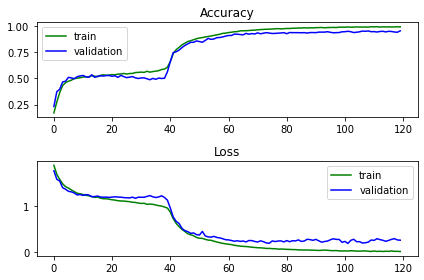

In [37]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [38]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도       복도
필웅이 는 어디 야 ?        : 화장실      화장실
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 사무실      사무실
수종이 는 어디 야 ?        : 사무실      복도
필웅이 는 어디 야 ?        : 부엌       부엌
필웅이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 사무실      사무실
필웅이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
은경이 는 어디 야 ?        : 부엌       부엌
은경이 는 어디 야 ?        : 정원       정원
은경이 는 어디 야 ?        : 부엌       부엌
수종이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 부엌       부엌
필웅이 는 어디 야 ?        : 복도       복도
은경이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 사무실      사무실
경임이 는 어디 야 ?        : 복도       복도
수종이 는 어디 야 ?        : 침실       침실
경임이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
수종이

#### 회고록  
적절한 전처리를 통해 답변을 완성하고 이를 메모리 네트워크를 통해 학습시킨 결과가 놀라웠다.  
챗봇에도 이러한 전처리를 거치고 메모리 네트워크를 적용하면 충분히 활용할만하다고 생각했다.